<b>Universidad Galileo</b><br/>
<b>Maestría de Ciencia de Datos</b><br/>
<b>Statistical Learning I</b><br/>
<b>Jose Godoy</b><br/>
<b>Carnet 22000570</b><br/>
<b>22 de junio 2022</b><br/>

# 1. Sección de configuración

## 1.1 Liberías

Carga de librerías generales

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1.2 Variables Globales

In [2]:
#Exactitud utilizada en todos los modelos
GLOBAL_EXACTITUD = 0.8
#Datos CSV sin alterar
GLOBAL_DATOS = pd.read_csv("data_titanic_proyecto.csv")
#Porcentaje de datos de entrenamiento
GLOBAL_SET_ENTRENAMIENTO = 0.8
#Porcentaje de datos de validación
GLOBAL_SET_VALIDACION = 0.2

# 2. Preprocesamiento

## 2.1 Train-val-test split

In [3]:
TVTS_data = GLOBAL_DATOS.copy()
TVTS_data.shape

(891, 12)

Indices aleatorios

In [4]:
np.random.seed(2022)

Indices prueba

In [5]:
longitud = len(TVTS_data)
TVTS_indices_entrenamiento = np.random.choice(longitud, round(longitud * GLOBAL_SET_ENTRENAMIENTO), replace=False)
TVTS_indices_prueba = np.array(list(set(range(longitud)) - set(TVTS_indices_entrenamiento)))

Datos prueba

In [6]:
TVTS_data_prueba = TVTS_data.iloc[TVTS_indices_prueba,:].copy()
TVTS_data_entrenamiento = TVTS_data.iloc[TVTS_indices_entrenamiento,:]

Indices de entrenamiento y validación

In [7]:
longitud = len(TVTS_data_entrenamiento)
TVTS_indices_validacion = np.random.choice(longitud, round(longitud * GLOBAL_SET_VALIDACION), replace=False)
TVTS_indices_entrenamiento = np.array(list(set(range(longitud)) - set(TVTS_indices_validacion)))

Datos de entrenamiento y validación

In [8]:
TVTS_data_validacion = TVTS_data_entrenamiento.iloc[TVTS_indices_validacion,:].copy()
TVTS_data_entrenamiento = TVTS_data_entrenamiento.iloc[TVTS_indices_entrenamiento,:].copy()

Guardando CSV de datos de prueba

In [9]:
TVTS_data_prueba.to_csv("TVTS_data_prueba.csv", index=False)

Eliminación de variables con los datos de prueba:

In [10]:
del TVTS_data_prueba
del TVTS_data
del GLOBAL_DATOS

## 2.2 Analisis exploratorio

Los datos son los siguientes:

In [11]:
AE_feature_engineering = TVTS_data_entrenamiento.copy()
AE_feature_engineering

,PassengerId,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,passenger_class,passenger_sex,passenger_survived
770,771,"Lievens, Mr. Rene Aime",24.00,0,0,345781,9.5000,NaN,S,Lower,M,N
178,179,"Hale, Mr. Reginald",30.00,0,0,250653,13.0000,NaN,S,Middle,M,N
159,160,"Sage, Master. Thomas Henry",NaN,8,2,CA. 2343,69.5500,NaN,S,Lower,M,N
656,657,"Radeff, Mr. Alexander",NaN,0,0,349223,7.8958,NaN,S,Lower,M,N
471,472,"Cacic, Mr. Luka",38.00,0,0,315089,8.6625,NaN,S,Lower,M,N
...,...,...,...,...,...,...,...,...,...,...,...,...
803,804,"Thomas, Master. Assad Alexander",0.42,0,1,2625,8.5167,NaN,C,Lower,M,Y
445,446,"Dodge, Master. Washington",4.00,0,2,33638,81.8583,A34,S,Upper,M,Y
365,366,"Adahl, Mr. Mauritz Nils Martin",30.00,0,0,C 7076,7.2500,NaN,S,Lower,M,N
611,612,"Jardin, Mr. Jose Neto",NaN,0,0,SOTON/O.Q. 3101305,7.0500,NaN,S,Lower,M,N


### 2.2.1 Eliminación de características específicas

Se eliminará ID de pasajero "passengerID" y nombre.

In [12]:
del AE_feature_engineering["PassengerId"]
del AE_feature_engineering["Name"]

### 2.2.2 Imputación de datos faltantes

A continuación se listan la cantidad de registros en cada columna que tienen valores NAN:

In [13]:
for col in AE_feature_engineering.columns:
    AE_columnas_nan = AE_feature_engineering[col].isnull().sum().sum()
    if(AE_columnas_nan>0):
        print(col+":", AE_columnas_nan)

Age: 112
Cabin: 445
Embarked: 1


#### 2.2.2.1 Analisis de densidad de la columna Year:

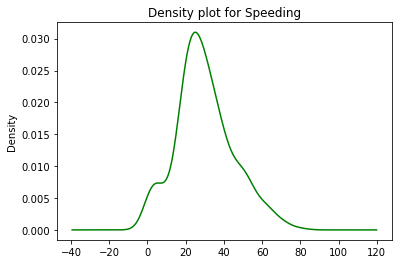

In [14]:
AE_age_nonan = AE_feature_engineering["Age"].notnull()
AE_feature_engineering["Age"][AE_age_nonan].plot.density(color='green')
plt.title('Density plot for Speeding')
plt.show()

Se utilizará un numero aleatorio utilizando una distribución normal. No se utilizará la media para no crear un outlayer:

In [15]:
AE_age_nan = AE_feature_engineering["Age"].isnull()
AE_age_mean = AE_feature_engineering["Age"][AE_age_nonan].mean(axis=0)
AE_age_std = AE_feature_engineering["Age"][AE_age_nonan].std(axis=0)
AE_age_random = np.random.normal(AE_age_mean, AE_age_std, sum(AE_age_nan))

AE_feature_engineering.columns.get_loc("Age")

AE_feature_engineering.loc[AE_age_nan, "Age"] = AE_age_random

#### 2.2.2.2 Analisis de las columna categórica Cabin

Porcentaje de datos faltantes:

In [16]:
print(sum(AE_feature_engineering["Cabin"].isnull())*100/len(AE_feature_engineering["Cabin"]))

78.0701754385965


En el siguiente gráfico se visualiza la gráfica de densidad para Cabin:

<AxesSubplot:>

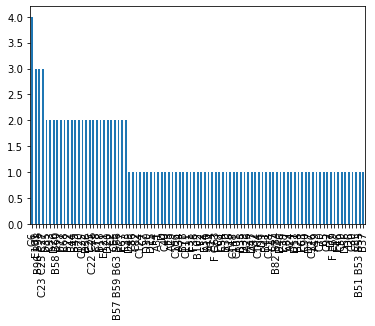

In [17]:
AE_cabin_nonan = AE_feature_engineering["Cabin"].notnull()
AE_cabin_repitencia = AE_feature_engineering["Cabin"][AE_cabin_nonan].value_counts()
AE_cabin_repitencia.plot(kind='bar')

La reptiencia máxima de Cabin es 'G6', este valor aparece solo 4 veces. Es necesario considerar que solo se tienen 4 registros con est

In [18]:
print("Registros que se repiten 4 veces:", len(AE_cabin_repitencia[AE_cabin_repitencia==4])/len(AE_cabin_repitencia))
print("Registros que se repiten 3 veces:", len(AE_cabin_repitencia[AE_cabin_repitencia==3])/len(AE_cabin_repitencia))
print("Registros que se repiten 2 veces:", len(AE_cabin_repitencia[AE_cabin_repitencia==2])/len(AE_cabin_repitencia))
print("Registros que se repiten 1 vez:", len(AE_cabin_repitencia[AE_cabin_repitencia==1])/len(AE_cabin_repitencia))

Registros que se repiten 4 veces: 0.010752688172043012
Registros que se repiten 3 veces: 0.03225806451612903
Registros que se repiten 2 veces: 0.24731182795698925
Registros que se repiten 1 vez: 0.7096774193548387


Para la columna Kabin se considera que no existe suficiente información para hacer imputación de datos. Se eliminará la columna.

In [19]:
del AE_feature_engineering["Cabin"]

#### 2.2.2.3 Analisis de densidad de la columna Embarked:

Existen pocos valores nan en la columna Embarked, a continuación se lista la repitencia de valores para esta columna:

In [20]:
AE_embarked_nonan = AE_feature_engineering["Embarked"].notnull()
AE_embarked_repitencia = AE_feature_engineering["Embarked"][AE_cabin_nonan].value_counts()
AE_embarked_repitencia

S    74
C    46
Q     4
Name: Embarked, dtype: int64

Se realizará imputación con el valor más repetido:

In [21]:
AE_embarked_mas_repetido = AE_embarked_repitencia[AE_embarked_repitencia==AE_embarked_repitencia[0]].axes[0].tolist()
AE_embarked_nan = AE_feature_engineering["Embarked"].isnull()
AE_feature_engineering.loc[AE_embarked_nan, "Embarked"] = AE_embarked_mas_repetido

### 2.2.3 Codificación de variables categóricas

El dataset hasta ahora es:

In [22]:
AE_feature_engineering

,Age,SibSp,Parch,Ticket,Fare,Embarked,passenger_class,passenger_sex,passenger_survived
770,24.000000,0,0,345781,9.5000,S,Lower,M,N
178,30.000000,0,0,250653,13.0000,S,Middle,M,N
159,38.841137,8,2,CA. 2343,69.5500,S,Lower,M,N
656,36.479933,0,0,349223,7.8958,S,Lower,M,N
471,38.000000,0,0,315089,8.6625,S,Lower,M,N
...,...,...,...,...,...,...,...,...,...
803,0.420000,0,1,2625,8.5167,C,Lower,M,Y
445,4.000000,0,2,33638,81.8583,S,Upper,M,Y
365,30.000000,0,0,C 7076,7.2500,S,Lower,M,N
611,36.444048,0,0,SOTON/O.Q. 3101305,7.0500,S,Lower,M,N


#### 2.2.3.1 Columna Ticket

A continuación se muestra la repetición de cada valor único:

In [23]:
AE_feature_engineering.Ticket.value_counts()

CA. 2343        5
1601            5
CA 2144         5
3101295         5
S.O.C. 14879    5
               ..
363592          1
24160           1
C.A. 6212       1
248747          1
11771           1
Name: Ticket, Length: 468, dtype: int64

La columna ticket será reemplazada según su repetición.

In [24]:
AE_valores_Ticket = AE_feature_engineering.Ticket.value_counts().axes[0].tolist()
AE_repitencia_Ticket = np.array(AE_feature_engineering.Ticket.value_counts())
AE_feature_engineering['Ticket'].replace(AE_valores_Ticket, AE_repitencia_Ticket, inplace=True)

#### 2.2.3.2 Columna Embarked

A continuación se muestra la repetición de cada valor único:

In [25]:
AE_feature_engineering.Embarked.value_counts()

S    406
C    106
Q     58
Name: Embarked, dtype: int64

La columna ticket será reemplazada utilizando one hot encoding.

In [26]:
AE_Embarked_OHE = pd.get_dummies(AE_feature_engineering.Embarked, prefix="Embarked")
AE_feature_engineering = pd.concat([AE_feature_engineering, AE_Embarked_OHE], axis=1)
del AE_feature_engineering["Embarked"]

#### 2.2.3.3 Columna passenger_class

A continuación se muestra la repetición de cada valor único:

In [27]:
AE_feature_engineering.passenger_class.value_counts()

Lower     314
Upper     132
Middle    124
Name: passenger_class, dtype: int64

La columna ticket será reemplazada utilizando one hot encoding.

In [28]:
AE_passenger_class_OHE = pd.get_dummies(AE_feature_engineering.passenger_class, prefix="passenger_class")
AE_feature_engineering = pd.concat([AE_feature_engineering, AE_passenger_class_OHE], axis=1)
del AE_feature_engineering["passenger_class"]

#### 2.2.3.3 Columna passenger_sex

A continuación se muestra la repetición de cada valor único:

In [29]:
AE_feature_engineering.passenger_sex.value_counts()

M    375
F    195
Name: passenger_sex, dtype: int64

Al ser una variable binaria, se representará de la siguiente forma: 1 = es hombre, 0 es mujer.

In [30]:
AE_sexo = AE_feature_engineering["passenger_sex"] == "M"
AE_feature_engineering["passenger_sex"] = AE_sexo.astype('int')

#### 2.2.3.3 Columna passenger_survived

A continuación se muestra la repetición de cada valor único:

In [31]:
AE_feature_engineering.passenger_survived.value_counts()

N    349
Y    221
Name: passenger_survived, dtype: int64

Esta es la variable que se debe predecir en el modelo con clasificación binaria, se utilizará 1 = Y (sobrevivió) y 0 = N (no sobrevivió).

In [32]:
AE_sobrevivio = AE_feature_engineering["passenger_survived"] == "Y"
AE_feature_engineering["passenger_survived"] = AE_sobrevivio.astype('int')

### 2.2.4 Tratamiento de Outliers

#### 2.2.4.1 Función para outliers

Función para tratar outlayers

In [33]:
def AE_tratamiento_outlier(AE_dataframe, AE_columnas):
    AE_parametros_outliers = pd.DataFrame()
    for AE_columna in AE_columnas:
        AE_quartiles = np.array( AE_dataframe[AE_columna].quantile([.25, .5, .75]) )
        AE_irq = AE_quartiles[2] - AE_quartiles[0]
        AE_limite_inferior = AE_quartiles[0] - AE_irq*1.5
        AE_limite_superior = AE_quartiles[2] + AE_irq*1.5
        AE_mean_to = AE_dataframe[AE_columna].mean(axis=0)
        AE_median_to = AE_dataframe[AE_columna].median(axis=0)
        
        AE_parametros_outliers = pd.concat([
            AE_parametros_outliers, 
            pd.DataFrame(data = {
                "columna": [AE_columna],
                "limite_inferior": [AE_limite_inferior], 
                "limite_superior": [AE_limite_superior], 
                "mean": [AE_mean_to], 
                "median": [AE_median_to]
            })
        ], ignore_index=True)
        
        AE_dataframe.loc[ AE_dataframe[AE_columna] <  AE_limite_inferior, AE_columna ] = AE_mean_to
        AE_dataframe.loc[ AE_dataframe[AE_columna] >  AE_limite_superior, AE_columna ] = AE_median_to
    return AE_parametros_outliers

#### 2.2.4.2 Gráfica BoxPlot

Gráficando BoxPlot para ver los outliers de las variables que no son one hot encoding:

<AxesSubplot:>

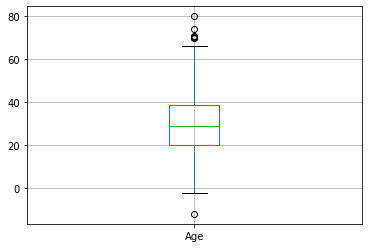

In [34]:
AE_feature_engineering.boxplot(column=['Age']) 

<AxesSubplot:>

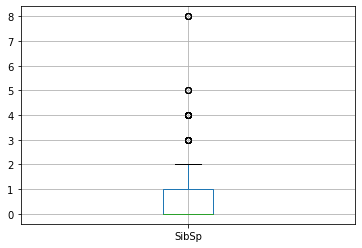

In [35]:
AE_feature_engineering.boxplot(column=['SibSp']) 

<AxesSubplot:>

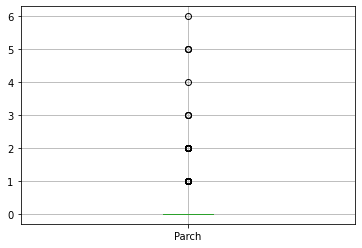

In [36]:
AE_feature_engineering.boxplot(column=['Parch']) 

<AxesSubplot:>

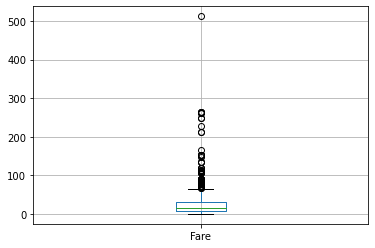

In [37]:
AE_feature_engineering.boxplot(column=['Fare']) 

#### 2.2.4.3 Eliminando outliers

In [38]:
AE_parametros_outliers = AE_tratamiento_outlier(AE_feature_engineering, ['Fare','Parch','SibSp', 'Age']) 

Parametros para tratamiento de outliers obtenidos:

In [39]:
AE_parametros_outliers

,columna,limite_inferior,limite_superior,mean,median
0,Fare,-26.760500,65.656300,31.695533,14.427100
1,Parch,0.000000,0.000000,0.387719,0.000000
2,SibSp,-1.500000,2.500000,0.538596,0.000000
3,Age,-7.386288,66.228617,29.849566,28.989187


Es posible ver cómo el límite inferior y superior de la columna Parch es 0. Esta columna no contiene información que sea de valor para el modelo. Se eliminará.

In [40]:
del AE_feature_engineering["Parch"]

### 2.2.4 Featuring scaling

Antes de normalizar lso datos se creará una gráfica de densidad para cada columna:

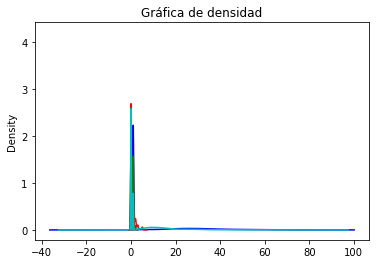

In [41]:
colors = "bgrcmykwbgrcmy"
index=0
for col in AE_feature_engineering.columns:
    AE_feature_engineering[col].plot.density(color=colors[index]) 
    index+=1 
plt.title('Gráfica de densidad') 
plt.show()

Estadísticos:

In [42]:
AE_statistics = AE_feature_engineering.describe()
AE_statistics = pd.concat([AE_statistics.loc["mean",:], AE_statistics.loc["std",:]], axis=1).transpose()
AE_statistics

,Age,SibSp,Ticket,Fare,passenger_sex,passenger_survived,Embarked_C,Embarked_Q,Embarked_S,passenger_class_Lower,passenger_class_Middle,passenger_class_Upper
mean,29.464296,0.301754,1.533333,17.062253,0.657895,0.387719,0.185965,0.101754,0.712281,0.550877,0.217544,0.231579
std,14.109149,0.530441,1.004267,12.508324,0.474831,0.487658,0.389420,0.302591,0.453097,0.497842,0.412938,0.422212


Normalizando:

In [43]:
AE_feature_engineering = (AE_feature_engineering - AE_statistics.loc["mean"]) / AE_statistics.loc["std"]
AE_feature_engineering

,Age,SibSp,Ticket,Fare,passenger_sex,passenger_survived,Embarked_C,Embarked_Q,Embarked_S,passenger_class_Lower,passenger_class_Middle,passenger_class_Upper
770,-0.387287,-0.568874,-0.531067,-0.604578,0.720477,-0.795064,-0.477543,-0.336277,0.635006,0.902140,-0.526820,-0.548490
178,0.037969,-0.568874,-0.531067,-0.324764,0.720477,-0.795064,-0.477543,-0.336277,0.635006,-1.106531,1.894852,-0.548490
159,0.664593,-0.568874,3.451936,-0.210672,0.720477,-0.795064,-0.477543,-0.336277,0.635006,0.902140,-0.526820,-0.548490
656,0.497240,-0.568874,-0.531067,-0.732828,0.720477,-0.795064,-0.477543,-0.336277,0.635006,0.902140,-0.526820,-0.548490
471,0.604977,-0.568874,-0.531067,-0.671533,0.720477,-0.795064,-0.477543,-0.336277,0.635006,0.902140,-0.526820,-0.548490
...,...,...,...,...,...,...,...,...,...,...,...,...
803,-2.058543,-0.568874,-0.531067,-0.683189,0.720477,1.255554,2.090378,-0.336277,-1.572026,0.902140,-0.526820,-0.548490
445,-1.804807,-0.568874,-0.531067,-0.210672,0.720477,1.255554,-0.477543,-0.336277,0.635006,-1.106531,-0.526820,1.819989
365,0.037969,-0.568874,-0.531067,-0.784458,0.720477,-0.795064,-0.477543,-0.336277,0.635006,0.902140,-0.526820,-0.548490
611,0.494697,-0.568874,-0.531067,-0.800447,0.720477,-0.795064,-0.477543,-0.336277,0.635006,0.902140,-0.526820,-0.548490


Si volvemos a graficar el dataframe, los datos estarán correctamente escalados:

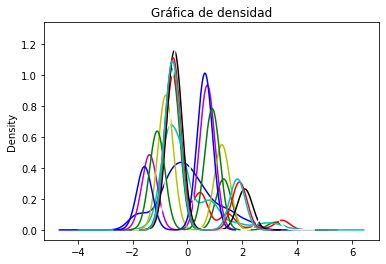

In [44]:
colors = "bgrcmykwbgrcmy"
index=0
for col in AE_feature_engineering.columns:
    AE_feature_engineering[col].plot.density(color=colors[index]) 
    index+=1 
plt.title('Gráfica de densidad') 
plt.show()

### 2.2.5 Análisis de correlación

Tabla de correlación:

In [92]:
#Correlación
AE_correlacion = AE_feature_engineering.corr()
pd.DataFrame(AE_correlacion["passenger_survived"].sort_values(ascending=False))

,passenger_survived
passenger_survived,1.000000
passenger_class_Upper,0.271617
Embarked_C,0.174927
SibSp,0.171975
Fare,0.125201
passenger_class_Middle,0.060419
Ticket,0.032776
Embarked_Q,0.006101
Age,-0.092847
Embarked_S,-0.154418


Se eliminarán las columnas con menos valor de correlación:

In [113]:
del AE_feature_engineering["passenger_class_Middle"]
del AE_feature_engineering["Ticket"]
del AE_feature_engineering["Embarked_Q"]